In [ ]:
# Mount Google Drive
from google.colab import drive # import drive from google colab

ROOT = "/content/drive"     # default location for the drive
print(ROOT)                 # print content of ROOT (Optional)

drive.mount(ROOT)           # we mount the google drive at /content/drive

/content/drive
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import os
import re
import pickle
from tqdm import tqdm
from itertools import product
from collections import defaultdict
from operator import itemgetter
from string import punctuation
from prettytable import PrettyTable

In [ ]:
# data folder
DATA_FOLDER = "/content/drive/My Drive/Predict Future Sales"

In [ ]:
# the training set. Daily historical data from January 2013 to October 2015.
dfSaleTrain = pd.read_csv(f'{DATA_FOLDER}/sales_train.csv')
# supplemental information about the items/products.
dfItems = pd.read_csv(f'{DATA_FOLDER}/items.csv')
# supplemental information about the items categories.
dfCategorie = pd.read_csv(f'{DATA_FOLDER}/item_categories.csv')
# supplemental information about the shops.
dfShop = pd.read_csv(f'{DATA_FOLDER}/shops.csv')
# supplemental information about the items/products
dfTest = pd.read_csv(f'{DATA_FOLDER}/test.csv')

# Understand `sales_train`
*   date - date in format dd.mm.yyyy
*   date_block_num - a consecutive month number, used for convenience. January 2013 is 0, February 2013 is 1,..., October 2015 is 33
* shop_id - unique identifier of a shop
* item_id - unique identifier of a product
* item_price - current price of an item
* item_cnt_day - number of products sold. You are predicting a monthly amount of this measure




In [ ]:
# Display the first 5 rows
dfSaleTrain.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0


In [ ]:
# print information about the index dtype and columns, non-null values and memory usage
dfSaleTrain.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2935849 entries, 0 to 2935848
Data columns (total 6 columns):
 #   Column          Dtype  
---  ------          -----  
 0   date            object 
 1   date_block_num  int64  
 2   shop_id         int64  
 3   item_id         int64  
 4   item_price      float64
 5   item_cnt_day    float64
dtypes: float64(2), int64(3), object(1)
memory usage: 134.4+ MB


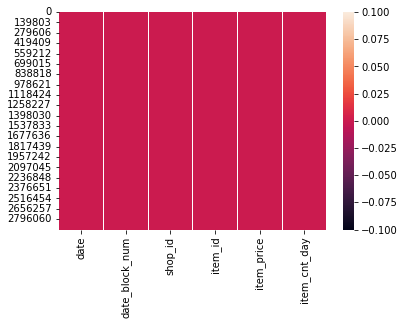

In [ ]:
# checking and removing NaN values
sns.heatmap(dfSaleTrain.isna())

No Nan values found

In [ ]:
# item_price can't be negative or zero
dfSaleTrain[dfSaleTrain['item_price'] <= 0]

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
484683,15.05.2013,4,32,2973,-1.0,1.0


In [ ]:
# removing negative priced items
dfSaleTrain = dfSaleTrain[dfSaleTrain['item_price'] > 0]

In [ ]:
# item_cnt_day can't be negative - assuming the items were refunded
iNegItemsSold = dfSaleTrain['item_cnt_day'][dfSaleTrain['item_cnt_day'] < 0].shape[0]
print('Total number of negative values:', iNegItemsSold)
print('Percentage of negative values', iNegItemsSold * 100 / dfSaleTrain.shape[0])

Total number of negative values: 7356
Percentage of negative values 0.25055793079205735


In [ ]:
# we will set the negative values to zero
dfSaleTrain['item_cnt_day'] = dfSaleTrain['item_cnt_day'].apply(lambda iNoProductsSold: 0 if iNoProductsSold < 0 else iNoProductsSold)
# item_cnt_day can't be floating
dfSaleTrain['item_cnt_day'] = dfSaleTrain['item_cnt_day'].apply(lambda iNoProductsSold: np.round(iNoProductsSold))

In [ ]:
# number of distinct values of number of products sold
dfSaleTrain['item_cnt_day'].nunique()

190

In [ ]:
print('Min item price:', dfSaleTrain['item_price'].min())
print('Max item price:', dfSaleTrain['item_price'].max())

Min item price: 0.07
Max item price: 307980.0


In [ ]:
print('Min number of products sold:', dfSaleTrain['item_cnt_day'].min())
print('Max number of products sold:', dfSaleTrain['item_cnt_day'].max())

Min number of products sold: 0.0
Max number of products sold: 2169.0


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warni

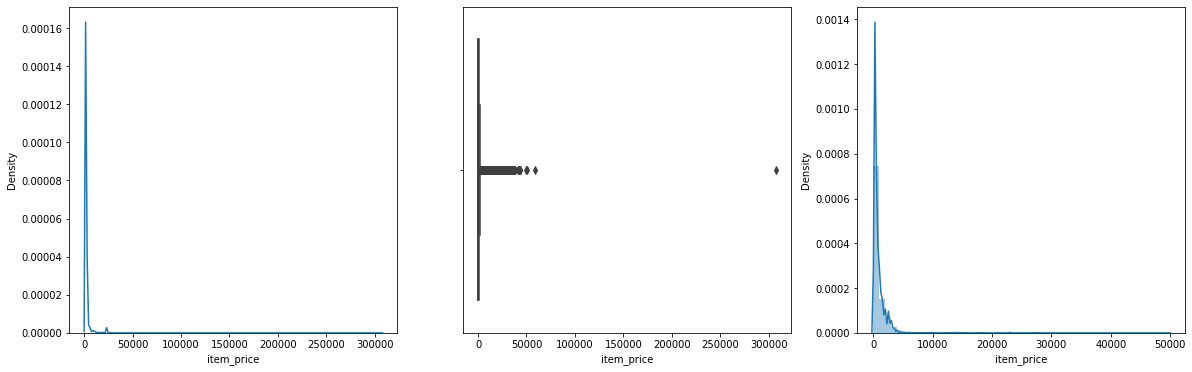

In [ ]:
# Create a figure with 3 subplots
oFig, caAxes = plt.subplots(ncols=3, figsize=(20, 6))
# Observe univariate distribution of item prices
sns.distplot(dfSaleTrain['item_price'], hist=False, ax=caAxes[0])
# distribution with respect to categories of item prices
sns.boxplot(dfSaleTrain['item_price'], ax=caAxes[1])
# Observe univariate distribution of item prices which are smaller than 50000
sns.distplot(dfSaleTrain['item_price'][dfSaleTrain['item_price'] < 50000], ax=caAxes[2])

In [ ]:
# removing all values greater than 100,000 as considering outiliers from `item_price` column
dfSaleTrain = dfSaleTrain[dfSaleTrain['item_price'] < 100000]

## Understand date-based data

In [ ]:
# Make a copy of sale training dataset
dfDatewiseSaleTrain = dfSaleTrain.copy()
# Convert `date` to datetime
dfDatewiseSaleTrain['date'] =  pd.to_datetime(dfDatewiseSaleTrain['date'])
# Set the column `date` as index
dfDatewiseSaleTrain.set_index('date', inplace=True)

In [ ]:
# Display the first 5 rows
dfDatewiseSaleTrain.head()

,date_block_num,shop_id,item_id,item_price,item_cnt_day
date,,,,,
2013-02-01,0,59,22154,999.00,1.0
2013-03-01,0,25,2552,899.00,1.0
2013-05-01,0,25,2552,899.00,0.0
2013-06-01,0,25,2554,1709.05,1.0
2013-01-15,0,25,2555,1099.00,1.0


Text(0, 0.5, '#no of items sold')

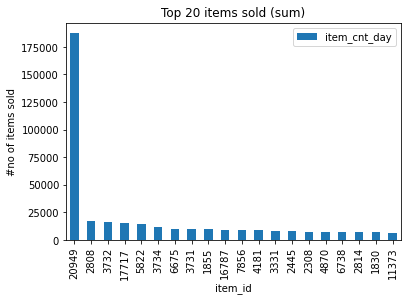

In [ ]:
# Get top 20 items sold
dfDatewiseSaleTrain.drop(['date_block_num','shop_id', 'item_price'], axis=1).groupby(['item_id']).sum().sort_values(by='item_cnt_day', ascending=False)[:20].plot(kind='bar')
plt.title('Top 20 items sold (sum)')
plt.ylabel('#no of items sold')

Text(0, 0.5, '#no of items sold')

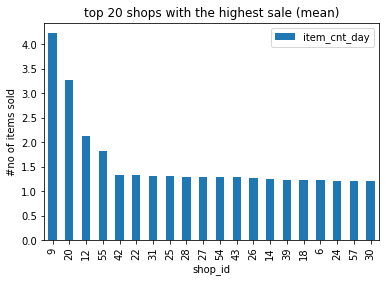

In [ ]:
# Get top 20 shops with the highest sale
dfDatewiseSaleTrain.drop(['date_block_num','item_id', 'item_price'], axis=1).groupby(['shop_id']).mean().sort_values(by='item_cnt_day', ascending=False)[:20].plot(kind='bar')
plt.title('top 20 shops with the highest sale (mean)')
plt.ylabel('#no of items sold')

In [ ]:
# Downsample the series into month bins and sum the values of the timestamps falling into a bin.
dfMonthlySumSaleTrain = dfDatewiseSaleTrain.resample('M').sum()
dfMonthlySumSaleTrain['month'] = dfMonthlySumSaleTrain.index.month

# Downsample the series into month bins and mean of the values of the timestamps falling into a bin.
dfMonthlyMeanSaleTrain = dfDatewiseSaleTrain.resample('M').mean()
dfMonthlyMeanSaleTrain['month'] = dfMonthlyMeanSaleTrain.index.month

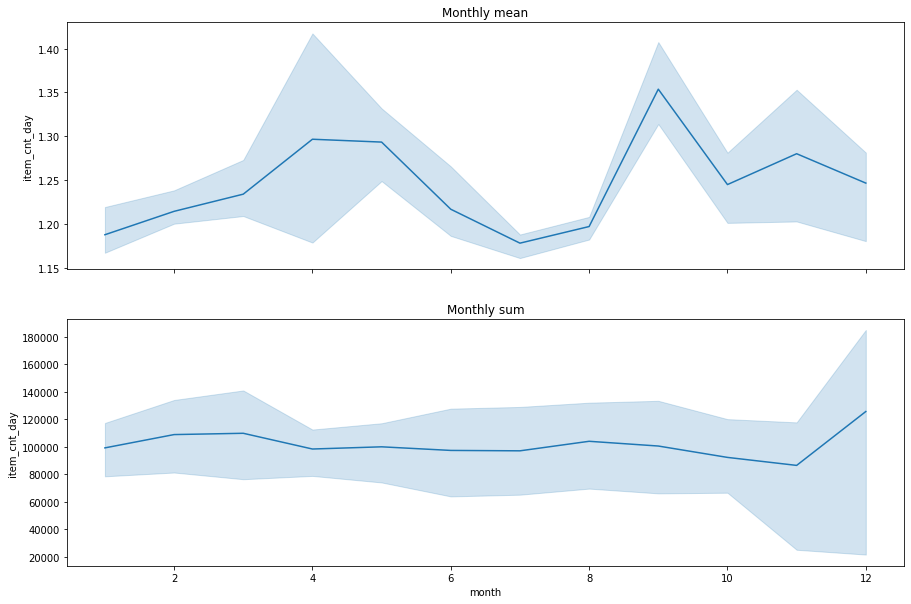

In [ ]:
# Create a figure with 2 subplots
oFig, caAxes = plt.subplots(2, 1, figsize=(15, 10), sharex=True)
# Draw a line plot of monthly mean of number of items sold
sns.lineplot(x="month", y="item_cnt_day", data=dfMonthlyMeanSaleTrain, ax=caAxes[0]).set_title("Monthly mean")
# Draw a line plot of monthly sum of number of items sold
sns.lineplot(x="month", y="item_cnt_day", data=dfMonthlySumSaleTrain, ax=caAxes[1]).set_title("Monthly sum")
plt.show()

# Understand `items`
* item_name - name of item
* item_id - unique identifier of a product
* item_category_id - unique identifier of item category

In [ ]:
# Display the first 5 rows
dfItems.head()

,item_name,item_id,item_category_id
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40
1,!ABBYY FineReader 12 Professional Edition Full...,1,76
2,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40
3,***ГОЛУБАЯ ВОЛНА (Univ) D,3,40
4,***КОРОБКА (СТЕКЛО) D,4,40


# Undestand `shops`
* shop_name - name of shop
* shop_id - unique identifier of a shop

In [ ]:
# Display the first 5 rows
dfShop.head(10)

,shop_name,shop_id
0,"!Якутск Орджоникидзе, 56 фран",0
1,"!Якутск ТЦ ""Центральный"" фран",1
2,"Адыгея ТЦ ""Мега""",2
3,"Балашиха ТРК ""Октябрь-Киномир""",3
4,"Волжский ТЦ ""Волга Молл""",4
5,"Вологда ТРЦ ""Мармелад""",5
6,"Воронеж (Плехановская, 13)",6
7,"Воронеж ТРЦ ""Максимир""",7
8,"Воронеж ТРЦ Сити-Парк ""Град""",8
9,Выездная Торговля,9


# Understanding `Categories`
* item_category_name - name of item category
* item_category_id - unique identifier of item category

In [ ]:
# Display the first 5 rows
dfCategorie.head()

,item_category_name,item_category_id
0,PC - Гарнитуры/Наушники,0
1,Аксессуары - PS2,1
2,Аксессуары - PS3,2
3,Аксессуары - PS4,3
4,Аксессуары - PSP,4


# Undestanding `test`
* ID - an Id that represents a (Shop, Item) tuple within the test set
* shop_id - unique identifier of a shop
* item_id - unique identifier of a product

In [ ]:
# Display the first 5 rows
dfTest.head()

,ID,shop_id,item_id
0,0,5,5037
1,1,5,5320
2,2,5,5233
3,3,5,5232
4,4,5,5268


In [ ]:
# the test data belongs to date_block_num 34
dfTest['date_block_num'] = 34
# item price is 0 by default
dfTest['item_price'] = 0
# number of products sold is 0 by default
dfTest['item_cnt_day'] = 0
# Display the first 5 rows
dfTest.head()

,ID,shop_id,item_id,date_block_num,item_price,item_cnt_day
0,0,5,5037,34,0,0
1,1,5,5320,34,0,0
2,2,5,5233,34,0,0
3,3,5,5232,34,0,0
4,4,5,5268,34,0,0


In [ ]:
# index columns
INDEX_COLS = ['shop_id', 'item_id', 'date_block_num']
# data columns
DATA_COLS = ['item_price', 'item_cnt_day']

In [ ]:
# Remove `date` column in traint set
dfTrain = dfSaleTrain[INDEX_COLS + DATA_COLS].copy()
# Remove `ID` column in test set
dfTest.drop(['ID'], axis=1, inplace=True)
# data with all the sales of train and test
dfTrainTest = dfTrain.append(dfTest, ignore_index=True)

In [ ]:
# Display the first 5 rows
dfTrainTest.head()

,shop_id,item_id,date_block_num,item_price,item_cnt_day
0,59,22154,0,999.00,1.0
1,25,2552,0,899.00,1.0
2,25,2552,0,899.00,0.0
3,25,2554,0,1709.05,1.0
4,25,2555,0,1099.00,1.0


In [ ]:
# Add revenue 
dfTrainTest['revenue'] = dfTrainTest['item_price'] * dfTrainTest['item_cnt_day']
# Add item category
dfTrainTest = dfTrainTest.join(dfItems[['item_id','item_category_id']].set_index('item_id'), on='item_id')
# Display first 5 rows in the data
dfTrainTest.head()

,shop_id,item_id,date_block_num,item_price,item_cnt_day,revenue,item_category_id
0,59,22154,0,999.00,1.0,999.00,37
1,25,2552,0,899.00,1.0,899.00,58
2,25,2552,0,899.00,0.0,0.00,58
3,25,2554,0,1709.05,1.0,1709.05,58
4,25,2555,0,1099.00,1.0,1099.00,56


In [ ]:
# For every month we create a grid from all shops/items combinations from that month
clShopItem = [] 
# Loop over all months
for iMonth in dfTrainTest['date_block_num'].unique():
    # all shop ids in this month
    dsShop = dfTrainTest[dfTrainTest['date_block_num']==iMonth]['shop_id'].unique()
    # all item ids in this month
    dsItem = dfTrainTest[dfTrainTest['date_block_num']==iMonth]['item_id'].unique()
    # all shops/items combinations from that month
    clShopItem.append(np.array(list(product(*[dsShop, dsItem, [iMonth]])), dtype='int32'))

# turn the grid into pandas dataframe
dfShopItem = pd.DataFrame(np.vstack(clShopItem), columns = INDEX_COLS, dtype=np.int32)

In [ ]:
# Display first 5 rows in the data
dfShopItem.head()

,shop_id,item_id,date_block_num
0,59,22154,0
1,59,2552,0
2,59,2554,0
3,59,2555,0
4,59,2564,0


# Aggregations

In [ ]:
# get aggregated values for (shop_id, item_id, month)
dfAggregatedMonth = dfTrainTest.groupby(INDEX_COLS, as_index=False).agg({'item_cnt_day':'sum', 'revenue':'sum'})
# Rename columns
dfAggregatedMonth.rename(columns={'item_cnt_day': 'target'}, inplace=True)
# join aggregated data to the orginal data
dfAggregatedTrainTest = dfShopItem.merge(dfAggregatedMonth, how='left', on=INDEX_COLS).fillna(0)
# sort the data
dfAggregatedTrainTest.sort_values(['date_block_num','shop_id','item_id'], inplace=True)
# Display first 5 rows in the data
dfAggregatedTrainTest.head()

,shop_id,item_id,date_block_num,target,revenue
139255,0,19,0,0.0,0.0
141495,0,27,0,0.0,0.0
144968,0,28,0,0.0,0.0
142661,0,29,0,0.0,0.0
138947,0,32,0,6.0,1326.0


In [ ]:
# add shop-month aggregates (shop_id, month)
dfAggregatedMonth = dfTrainTest.groupby(['shop_id', 'date_block_num'], as_index=False).agg({'item_cnt_day':'sum', 'revenue':'sum'})
# Rename columns
dfAggregatedMonth.rename(columns={"item_cnt_day": "target_shop", "revenue": "revenue_per_shop"}, inplace=True)
# join aggregated data to the orginal data
dfAggregatedTrainTest = dfAggregatedTrainTest.merge(dfAggregatedMonth, how='left', on=['shop_id', 'date_block_num']).fillna(0)
# Display first 5 rows in the data
dfAggregatedTrainTest.head()

,shop_id,item_id,date_block_num,target,revenue,target_shop,revenue_per_shop
0,0,19,0,0.0,0.0,5578.0,2966412.0
1,0,27,0,0.0,0.0,5578.0,2966412.0
2,0,28,0,0.0,0.0,5578.0,2966412.0
3,0,29,0,0.0,0.0,5578.0,2966412.0
4,0,32,0,6.0,1326.0,5578.0,2966412.0


In [ ]:
# add item-month aggregates (item_id, month)
dfAggregatedMonth = dfTrainTest.groupby(['item_id', 'date_block_num'], as_index=False).agg({'item_cnt_day':'sum', 'revenue':'sum'})
# Rename columns
dfAggregatedMonth.rename(columns={"item_cnt_day": "target_item", "revenue": "revenue_per_item"}, inplace=True)
# join aggregated data to the orginal data
dfAggregatedTrainTest = dfAggregatedTrainTest.merge(dfAggregatedMonth, how='left', on=['item_id', 'date_block_num']).fillna(0)
# Display first 5 rows in the data
dfAggregatedTrainTest.head()

,shop_id,item_id,date_block_num,target,revenue,target_shop,revenue_per_shop,target_item,revenue_per_item
0,0,19,0,0.0,0.0,5578.0,2966412.0,1.0,28.00
1,0,27,0,0.0,0.0,5578.0,2966412.0,7.0,16275.00
2,0,28,0,0.0,0.0,5578.0,2966412.0,8.0,4392.00
3,0,29,0,0.0,0.0,5578.0,2966412.0,5.0,11886.00
4,0,32,0,6.0,1326.0,5578.0,2966412.0,299.0,101515.86


In [ ]:
# add item category-month aggregates (item_category_id, month)
dfAggregatedMonth = dfTrainTest.groupby(['item_category_id', 'date_block_num'], as_index=False).agg({'item_cnt_day':'sum', 'revenue':'sum'})
# Rename columns
dfAggregatedMonth.rename(columns={"item_cnt_day": "target_item_category", "revenue": "revenue_per_item_category"}, inplace=True)
# Join column `item_category_id`
dfAggregatedTrainTest = dfAggregatedTrainTest.merge(dfItems[['item_id','item_category_id']], how='left', on='item_id').fillna(0)
# join aggregated data to the orginal data
dfAggregatedTrainTest = dfAggregatedTrainTest.merge(dfAggregatedMonth, how='left', on=['item_category_id', 'date_block_num']).fillna(0)
# Display first 5 rows in the data
dfAggregatedTrainTest.head()

,shop_id,item_id,date_block_num,target,revenue,target_shop,revenue_per_shop,target_item,revenue_per_item,item_category_id,target_item_category,revenue_per_item_category
0,0,19,0,0.0,0.0,5578.0,2966412.0,1.0,28.00,40,33532.0,8678093.69
1,0,27,0,0.0,0.0,5578.0,2966412.0,7.0,16275.00,19,9024.0,14162479.79
2,0,28,0,0.0,0.0,5578.0,2966412.0,8.0,4392.00,30,22261.0,10032386.52
3,0,29,0,0.0,0.0,5578.0,2966412.0,5.0,11886.00,23,4172.0,7709925.53
4,0,32,0,6.0,1326.0,5578.0,2966412.0,299.0,101515.86,40,33532.0,8678093.69


In [ ]:
# add item-month average price
dfAggregatedTrainTest['target_item_price'] = dfAggregatedTrainTest['revenue_per_item'] / dfAggregatedTrainTest['target_item']
# Replace negative infinity to nan
dfAggregatedTrainTest['target_item_price'] = dfAggregatedTrainTest['target_item_price'].replace(-np.inf, np.nan)
# Replace positive infinity to nan
dfAggregatedTrainTest['target_item_price'] = dfAggregatedTrainTest['target_item_price'].replace(np.inf, np.nan)
# Fill nans
dfAggregatedTrainTest['target_item_price'] = dfAggregatedTrainTest['target_item_price'].fillna(0)
# Display first 5 rows in the data
dfAggregatedTrainTest.head()

,shop_id,item_id,date_block_num,target,revenue,target_shop,revenue_per_shop,target_item,revenue_per_item,item_category_id,target_item_category,revenue_per_item_category,target_item_price
0,0,19,0,0.0,0.0,5578.0,2966412.0,1.0,28.00,40,33532.0,8678093.69,28.000000
1,0,27,0,0.0,0.0,5578.0,2966412.0,7.0,16275.00,19,9024.0,14162479.79,2325.000000
2,0,28,0,0.0,0.0,5578.0,2966412.0,8.0,4392.00,30,22261.0,10032386.52,549.000000
3,0,29,0,0.0,0.0,5578.0,2966412.0,5.0,11886.00,23,4172.0,7709925.53,2377.200000
4,0,32,0,6.0,1326.0,5578.0,2966412.0,299.0,101515.86,40,33532.0,8678093.69,339.517926


In [ ]:
"""
    Function name: Downcastdtypes
    
    Objective: Change column types in the dataframe
    
    Summary algorithmic description: `float64` type to `float32`
                                     `int64`   type to `int32`
    
    Input parameters: dfData: dataframe
    
    Return : downcasted dataframe
    
    Date : 23/12/2021
    
    Coding: INSA CVL - Van Tuan BUI  
"""
def Downcastdtypes(dfData):
    # Select columns to downcast
    # floating columns
    clFloatColumn = [sColumn for sColumn in dfData if dfData[sColumn].dtype == "float64"]
    # integer columns
    clIntColumn = [sColumn for sColumn in dfData if dfData[sColumn].dtype == "int64"]
    
    # Downcast
    # `float64` type to `float32`
    dfData[clFloatColumn] = dfData[clFloatColumn].astype(np.float32)
    # `int64`   type to `int32`
    dfData[clIntColumn]   = dfData[clIntColumn].astype(np.int32)
    # Return downcasted dataframe
    return dfData

In [ ]:
# Downcast dtypes from 64 to 32 bit to save memory
dfAggregatedTrainTest = Downcastdtypes(dfAggregatedTrainTest)
# print information about the index dtype and columns, non-null values and memory usage
dfAggregatedTrainTest.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11128004 entries, 0 to 11128003
Data columns (total 13 columns):
 #   Column                     Dtype  
---  ------                     -----  
 0   shop_id                    int32  
 1   item_id                    int32  
 2   date_block_num             int32  
 3   target                     float32
 4   revenue                    float32
 5   target_shop                float32
 6   revenue_per_shop           float32
 7   target_item                float32
 8   revenue_per_item           float32
 9   item_category_id           int32  
 10  target_item_category       float32
 11  revenue_per_item_category  float32
 12  target_item_price          float32
dtypes: float32(9), int32(4)
memory usage: 636.7 MB


In [ ]:
print('Min target:', dfAggregatedTrainTest['target'].min())
print('Max target:', dfAggregatedTrainTest['target'].max())

Min target: 0.0
Max target: 2253.0


In [ ]:
# aggregated train data
dfAggregatedTrain = dfAggregatedTrainTest[dfAggregatedTrainTest['date_block_num'] < 34]
# Display first 5 rows in the data
dfAggregatedTrain.head()

,shop_id,item_id,date_block_num,target,revenue,target_shop,revenue_per_shop,target_item,revenue_per_item,item_category_id,target_item_category,revenue_per_item_category,target_item_price
0,0,19,0,0.0,0.0,5578.0,2966412.0,1.0,28.000000,40,33532.0,8678094.0,28.000000
1,0,27,0,0.0,0.0,5578.0,2966412.0,7.0,16275.000000,19,9024.0,14162480.0,2325.000000
2,0,28,0,0.0,0.0,5578.0,2966412.0,8.0,4392.000000,30,22261.0,10032387.0,549.000000
3,0,29,0,0.0,0.0,5578.0,2966412.0,5.0,11886.000000,23,4172.0,7709925.5,2377.199951
4,0,32,0,6.0,1326.0,5578.0,2966412.0,299.0,101515.859375,40,33532.0,8678094.0,339.517914


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


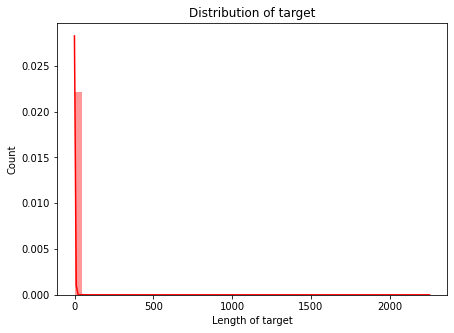

In [ ]:
# Create a new figure with a size (7,5)
plt.figure(figsize=(7,5))
# Show a default plot with a kernel density estimate and histogram with bin size determined automatically
sns.distplot(dfAggregatedTrain['target'], color='red')
# Set a title for the figure
plt.title('Distribution of target')
# Set the label for the x-axis
plt.xlabel('Value of target')
# Set the label for the y-axis
plt.ylabel('Count')
# Display the figure
plt.show()

In [ ]:
# target frequencies
cdTargetFreq = defaultdict(int)
# Loop over all values of target
for sKey in list(dfAggregatedTrain['target']):
    # Target frequency inscrease
    cdTargetFreq[sKey] += 1

# top 10 most frequents targets
cdSortedFreq = sorted(cdTargetFreq.items(), key=itemgetter(1), reverse=True)[0: 30]
# Result of top 10 most frequents targets
ctTopTarget, ctTopFreq = zip(*cdSortedFreq)

In [ ]:
print('There are total ', len(cdTargetFreq), ' different values of target.')

There are total  441  different values of target.


In [ ]:
# descending sort of target frequencies 
caTargetCount = sorted(list(cdTargetFreq.values()), reverse=True) / np.sum(list(cdTargetFreq.values()));
# the cumulative sum of the target frequencies 
caTargetCountCum = np.cumsum(caTargetCount)
# target frequency threshold
TARGET_FREQUENCY_THRESHOLD = 0.999
# first index of most target frequencies that covers about 99.9% of our train + test data 
iIdx = [iIdx for iIdx, fFreq in enumerate(caTargetCountCum) if fFreq > TARGET_FREQUENCY_THRESHOLD][0]
print(f'Top {iIdx + 1} target-value covers about {TARGET_FREQUENCY_THRESHOLD * 100}% of our train and test data')

Top 22 target-value covers about 99.9% of our train and test data


In [ ]:
# question frequency table
oTargetFrequencyTable = PrettyTable(["Target Value", "Target Count", "Coverage"])

for i in range(30):
    # Row of table
    clRow = []
    # Question Type
    clRow.append(ctTopTarget[i])
    # Question Count
    clRow.append(ctTopFreq[i])
    # Coverage of this question
    clRow.append(np.round((ctTopFreq[i] / sum(ctTopFreq)) * 100, 2))
    # Add this row
    oTargetFrequencyTable.add_row(clRow)

# Display the table 
print(oTargetFrequencyTable)

+--------------+--------------+----------+
| Target Value | Target Count | Coverage |
+--------------+--------------+----------+
|     0.0      |   9305579    |  85.32   |
|     1.0      |   1060053    |   9.72   |
|     2.0      |    266172    |   2.44   |
|     3.0      |    103481    |   0.95   |
|     4.0      |    53491     |   0.49   |
|     5.0      |    32037     |   0.29   |
|     6.0      |    20804     |   0.19   |
|     7.0      |    14087     |   0.13   |
|     8.0      |    10464     |   0.1    |
|     9.0      |     7546     |   0.07   |
|     10.0     |     6045     |   0.06   |
|     11.0     |     4486     |   0.04   |
|     12.0     |     3711     |   0.03   |
|     13.0     |     3066     |   0.03   |
|     14.0     |     2457     |   0.02   |
|     15.0     |     2075     |   0.02   |
|     16.0     |     1751     |   0.02   |
|     17.0     |     1576     |   0.01   |
|     18.0     |     1305     |   0.01   |
|     19.0     |     1106     |   0.01   |
|     20.0 

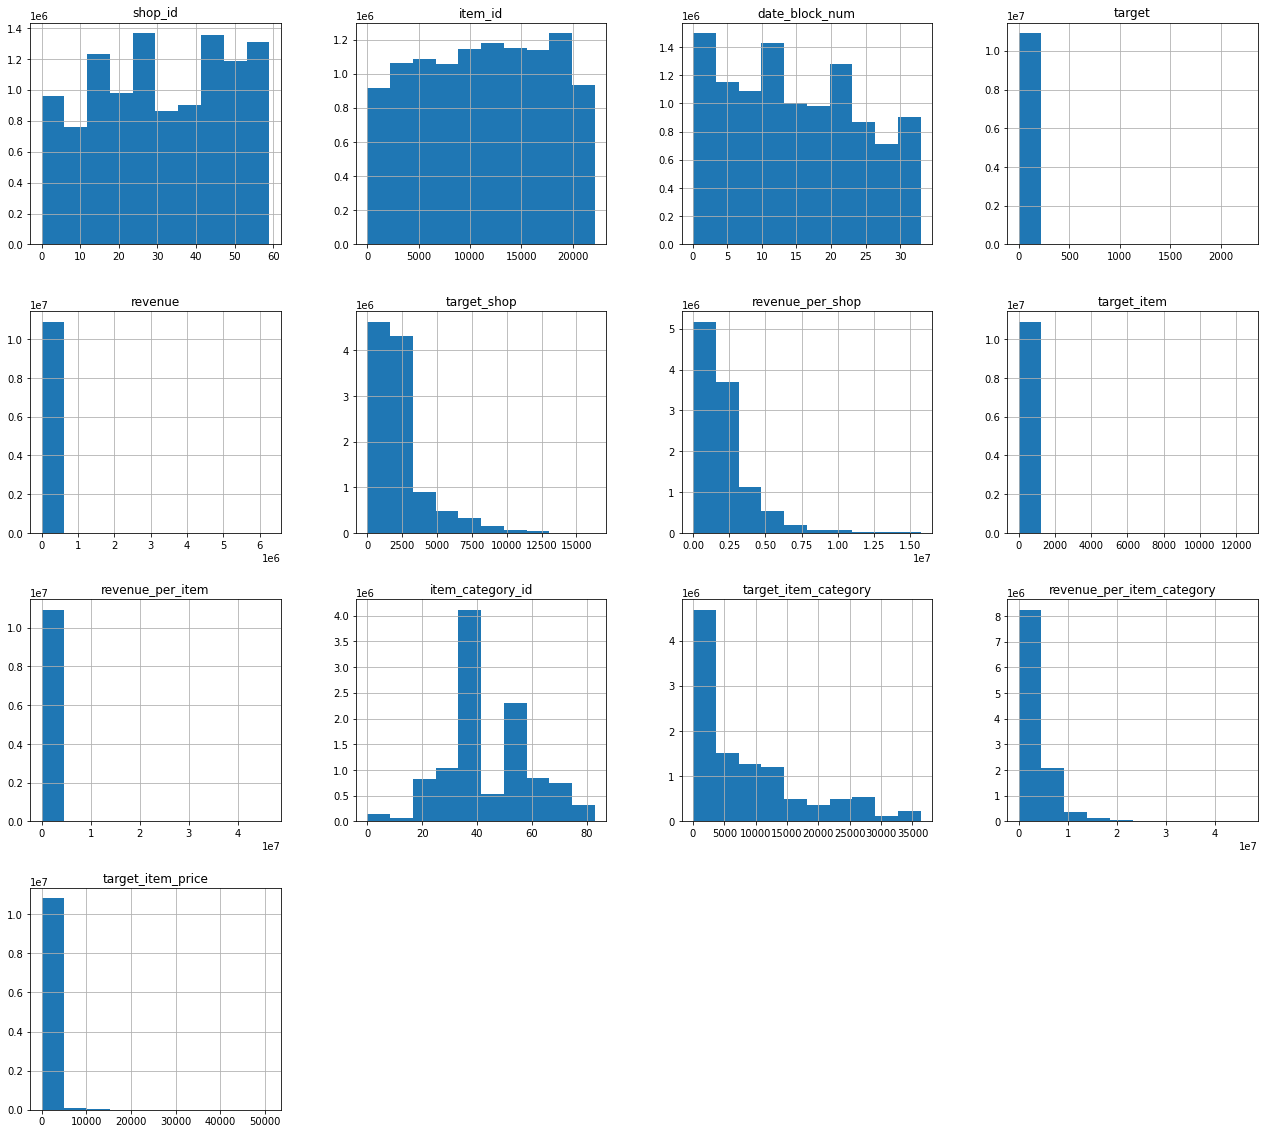

In [ ]:
# Data histograms
dfAggregatedTrain.hist(figsize = (22,20))
plt.show()

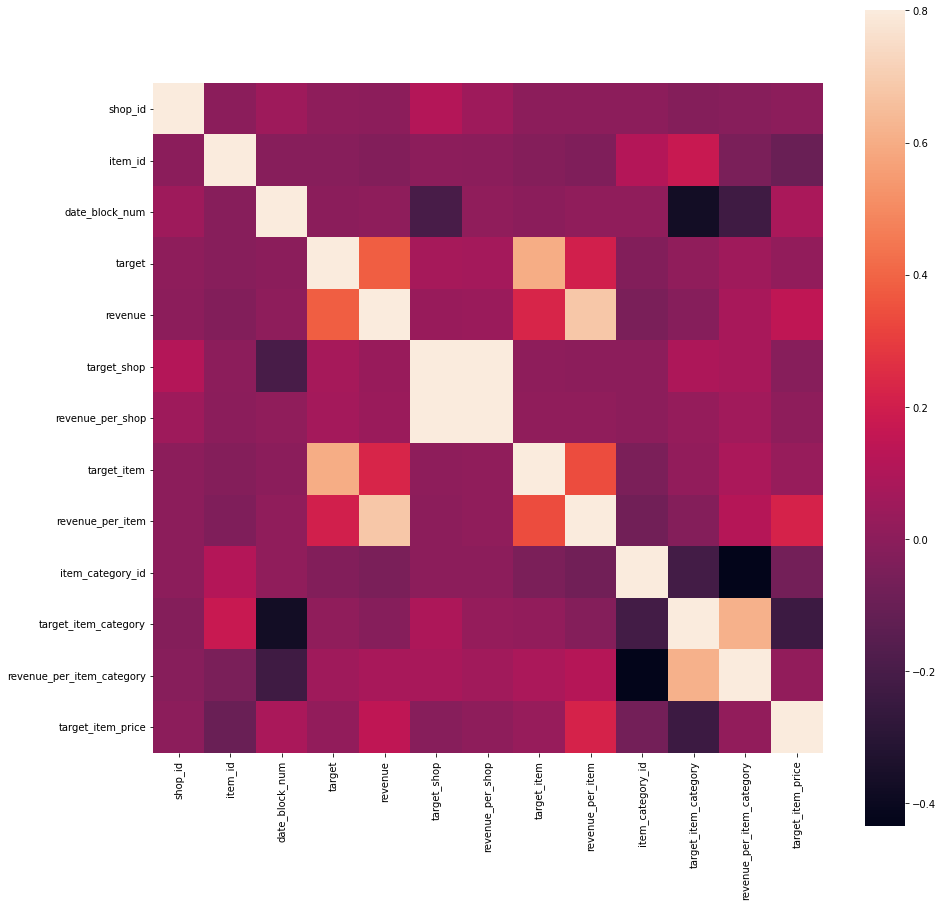

In [ ]:
# Correlations
# Compute pairwise correlation of columns, excluding NA/null values.
dfCorrMatrix = dfAggregatedTrain.corr()
# Create a new figure with a size (15,15)
oFig = plt.figure(figsize = (15,15))
# Plot a heatmap of correlation of columns
sns.heatmap(dfCorrMatrix, vmax = .8, square = True)
# Display the figure
plt.show()

The target is highly correlated with the item and the revenue but not much with the shop

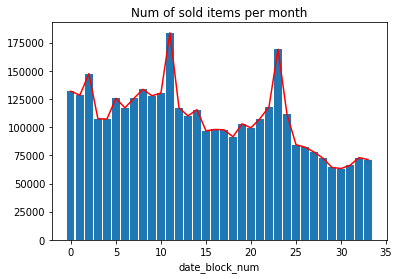

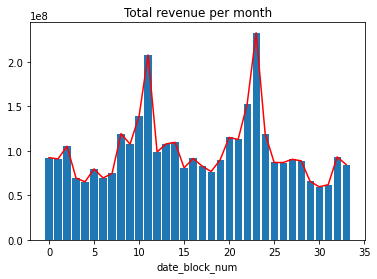

In [ ]:
# Number of sold items per month
dsTarget = dfAggregatedTrain.groupby(by='date_block_num')['target'].sum()
# Make plot of numbers of sold items per month
dsTarget.plot(color='red')
# Make a bar plot
plt.bar(dsTarget.index, dsTarget)
# Set a title for the figure
plt.title('Num of sold items per month')
# Display the figure
plt.show()

# Total revenue per month
dsRevenue = dfAggregatedTrain.groupby(by='date_block_num')['revenue'].sum()
# Make a plot
dsRevenue.plot(color='red')
# Make a bar plot
plt.bar(dsRevenue.index, dsRevenue)
# Set a title for the figure
plt.title('Total revenue per month')
# Display the figure
plt.show()

In [ ]:
# Write data to a csv file
dfAggregatedTrainTest.to_csv(os.path.join(DATA_FOLDER, 'matrix.csv'), sep='\t', index=False)